# Library import

In [71]:
import os
from PIL import Image
from torch.utils.data import Dataset
import torch.utils.data as data
from torchvision import datasets, transforms, utils
import torch
from torchvision.utils import save_image
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import wandb

from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score

import warnings
warnings.filterwarnings('ignore')

In [72]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device = {device}")

device = cuda


In [73]:
torch.cuda.empty_cache()

# Hyperparameters

In [74]:
model_name = "Original-Data"
eval_every = 1
save_every = 5

# est-ce qu'on pourrait pas faire des batch size différent pour le train et le test/validation ?
# as-tu d'autres idée d'hyperparametre ?
batch_size = 32
learning_rate = 0.001
nb_epochs = 100
proba_dropout = 0.2
kernel_size = 3

In [92]:
# if ask for a key, COPY/PASTE bc0dc5f66039bf86ffba73188a299faed907973c
wandb.init(
    project="deep_learning_project", 
    config = {
        "model": model_name,
        "batch_size": batch_size,
        "learning_rate": learning_rate,
        "nb_epochs": nb_epochs,
        "eval_every": eval_every,
        "save_every": save_every,
        "kernel_size": kernel_size,
        "proba_dropout": proba_dropout,
        "kernel_incr": "double",
        "Padding": "True",
        "BatchNorm": "True",
    },
    name=model_name,
    tags = ["test"],
)

In [31]:
# wandb.finish()

# Dataset import

In [6]:
print(os.getcwd())
os.chdir("/scratch/users/jwalraff/DeepWalraff/emotions_datasets")
print(os.getcwd())
print(os.listdir(os.getcwd()))

/home/jwalraff/DeepWalraff/project
/scratch/users/jwalraff/DeepWalraff/emotions_datasets
['emotion-detection-fer.zip', 'test', 'train']


In [75]:
import datasetCreation

root_dir = "/scratch/users/jwalraff/DeepWalraff/emotions_datasets"
test_dir = os.path.join(root_dir, "test")
categories = os.listdir(test_dir)

transform = transforms.Compose([
    transforms.ToTensor()
])

train_loader = datasetCreation.getDataLoader(root_dir, batch_size, num_workers= 4, mode='train', transform=transform)
test_loader = datasetCreation.getDataLoader(root_dir, batch_size, mode='test', transform=transform)

<class 'torch.Tensor'>


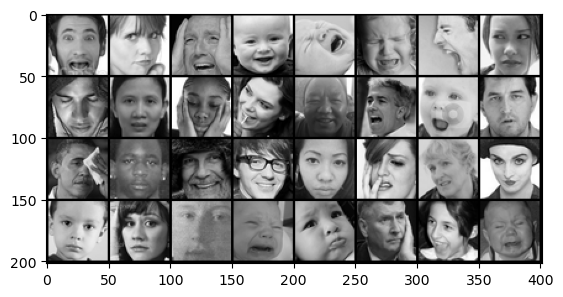

surprised sad sad happy sad sad angry angry sad fearful sad happy happy angry surprised neutral sad neutral happy happy neutral sad fearful neutral neutral fearful neutral fearful sad angry happy sad


In [76]:
# comes from hw2
def show_images(img):
    plt.imshow(transforms.functional.to_pil_image(img), cmap='gray')
    plt.show()

# show the images from a batch
images, labels = next(iter(train_loader))
print(type(images))
show_images(utils.make_grid(images))
print(*[categories[l] for l in labels])

# Class Weights

In [77]:
# source of the formula https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/
weights = []
category_count = []
n_category = len(categories)

for i, cat in enumerate(categories):
    tmp = os.path.join(test_dir, cat)
    category_count.append(len(os.listdir(tmp)))

n_sample = sum(category_count)    
    
for i, n_sample_i in enumerate(category_count):
    weights.append(n_sample/(n_category*n_sample_i))

weights = torch.tensor(weights, dtype=torch.float).to(device)
weights

tensor([1.0704, 9.2381, 1.0014, 0.5780, 0.8317, 0.8223, 1.2340],
       device='cuda:0')

# Model

# ON PEUT REGARDER L'EFFET D'AUGMENTER LES IN ET OUT CHANNEL, CA VA AUGMENTER LE NOMBRE DE PARAM EN GROS
# RAJOUT DE PADDIN ET BATCH NORM. FAUDRAIT-IL RAJOUTER DU DROPOUT DANS LES CONV LAYERS ?

# First model tested

class ConvNet_custom(nn.Module):
    def __init__(self):
        # basic architecture from slide 35/59 lecture 6 of deep learning course
        # INPUT → [[CONV → ReLU]*N → POOL?]*M → [FC → ReLU]*K → FC
        super(ConvNet_custom, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(64*10*10, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 7)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        print(f"x shape: {x.shape}")
        x = x.view(-1, 64*10*10) # pareil ici (pour le 64*73*73)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [17]:
convnet = ConvNet_custom()
convnet.train()

print(f"convnet architecture: \n{convnet}")

# from https://saturncloud.io/blog/check-the-total-number-of-parameters-in-a-pytorch-model/#:~:text=To%20check%20the%20number%20of%20parameters%20in%20a%20PyTorch%20model,its%20total%20number%20of%20elements
print(f"\n numbers of parameters: {sum(p.numel() for p in convnet.parameters())}")

# Loss and optimizer
criterion = nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.Adam(convnet.parameters(), lr=learning_rate)

convnet architecture: 
ConvNet_custom(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=6400, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=7, bias=True)
)

 numbers of parameters: 7630215


# 5 layers CNN (ON A TRES PEU DE PARAM, PE AUGMENTER LE NB DE KERNEL)

In [93]:
class ConvNet5Layers(nn.Module):
    def __init__(self, kernel_size, proba_dropout):
        # basic architecture from slide 35/59 lecture 6 of deep learning course
        # INPUT → [[CONV → ReLU]*N → POOL?]*M → [FC → ReLU]*K → FC
        super(ConvNet5Layers, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(kernel_size=2)
        
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.pool5 = nn.MaxPool2d(kernel_size=2)
        
        self.fc1 = nn.Linear(512, 256)
        self.bn6 = nn.BatchNorm1d(256)
        self.dropout6 = nn.Dropout(proba_dropout)
        
        self.fc2 = nn.Linear(256, 128)
        self.bn7 = nn.BatchNorm1d(128)
        self.dropout7 = nn.Dropout(proba_dropout)
        
        self.fc3 = nn.Linear(128, 7)  # 7 classes en sortie
        
    def forward(self, x):
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.pool1(x)
        
        x = self.bn2(F.relu(self.conv2(x)))
        x = self.pool2(x)
        
        x = self.bn3(F.relu(self.conv3(x)))
        x = self.pool3(x)
        
        x = self.bn4(F.relu(self.conv4(x)))
        x = self.pool4(x)
        
        x = self.bn5(F.relu(self.conv5(x)))
        x = self.pool5(x)
        
        x = torch.flatten(x, 1)
        
        x = self.bn6(F.relu(self.fc1(x)))
        x = self.dropout6(x)
        
        x = self.bn7(F.relu(self.fc2(x)))
        x = self.dropout7(x)
        
        x = self.fc3(x)
        return x

In [94]:
convnet = ConvNet5Layers(kernel_size, proba_dropout)
convnet.train()

print(f"convnet architecture: \n{convnet}")

# from https://saturncloud.io/blog/check-the-total-number-of-parameters-in-a-pytorch-model/#:~:text=To%20check%20the%20number%20of%20parameters%20in%20a%20PyTorch%20model,its%20total%20number%20of%20elements
print(f"\n numbers of parameters: {sum(p.numel() for p in convnet.parameters())}")

# Loss and optimizer
criterion = nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.Adam(convnet.parameters(), lr=learning_rate)

convnet architecture: 
ConvNet5Layers(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool2d(kernel_size=2,

# Paper Model test

In [84]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=128, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(128)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.dropout1 = nn.Dropout(0.25)
        
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(256)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.dropout2 = nn.Dropout(0.25)
        
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(512)
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        self.dropout3 = nn.Dropout(0.25)
        
        self.conv4 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(1024)
        self.pool4 = nn.MaxPool2d(kernel_size=2)
        self.dropout4 = nn.Dropout(0.25)
        
        self.conv5 = nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(1024)
        self.pool5 = nn.MaxPool2d(kernel_size=2)
        self.dropout5 = nn.Dropout(0.25)
        
        self.fc1 = nn.Linear(1024, 512)
        self.bn6 = nn.BatchNorm1d(512)
        self.dropout6 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(512, 256)
        self.bn7 = nn.BatchNorm1d(256)
        self.dropout7 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(256, 7)  # 7 classes en sortie

    def forward(self, x):
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.pool1(x)
        x = self.dropout1(x)
        
        x = self.bn2(F.relu(self.conv2(x)))
        x = self.pool2(x)
        x = self.dropout2(x)
        
        x = self.bn3(F.relu(self.conv3(x)))
        x = self.pool3(x)
        x = self.dropout3(x)
        
        x = self.bn4(F.relu(self.conv4(x)))
        x = self.pool4(x)
        x = self.dropout4(x)
        
        x = self.bn5(F.relu(self.conv5(x)))
        x = self.pool5(x)
        x = self.dropout5(x)
        
        x = torch.flatten(x, 1)
        
        x = self.bn6(F.relu(self.fc1(x)))
        x = self.dropout6(x)
        
        x = self.bn7(F.relu(self.fc2(x)))
        x = self.dropout7(x)
        
        x = self.fc3(x)
        return x

In [85]:
convnet = ConvNet()
convnet.train()

print(f"convnet architecture: \n{convnet}")

# from https://saturncloud.io/blog/check-the-total-number-of-parameters-in-a-pytorch-model/#:~:text=To%20check%20the%20number%20of%20parameters%20in%20a%20PyTorch%20model,its%20total%20number%20of%20elements
print(f"\n numbers of parameters: {sum(p.numel() for p in convnet.parameters())}")

# Loss and optimizer
criterion = nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.Adam(convnet.parameters(), lr=learning_rate)

convnet architecture: 
ConvNet(
  (conv1): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout(p=0.25, inplace=False)
  (conv4): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), paddin

# Training

In [95]:
def train_cnn(num_epochs):
    train_avg_loss = []
    validation_avg_loss = []
    validation_accuracy = []
    confidence_array = []

    # transfer cnn to GPU (in-place)
    convnet.to(device)

    print("Entering epoch loops.....")
    for i in range(num_epochs):
        train_losses = []
        validation_losses = []
        recall_scores = []
        precision_scores = []
        f1_scores = []
        
        print("Entering train loop....")
        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)
            pred = convnet(x)
            loss = criterion(pred, y)
            sample_weight = weights[y.data.view(-1).long()].view_as(y)
            loss = (loss * sample_weight).mean()

            train_losses.append(loss.cpu().detach())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss_mean = np.array(train_losses).mean()
        
        wandb.log({
                "epoch": i, 
                "train_loss": train_loss_mean
            })
        
        train_avg_loss.append(train_loss_mean)

        # à modifier en fonction du nb d'epoch qu'on met
        if i % eval_every == 0:
            print("Entering validation.....")
            with torch.no_grad():
                correct = 0

                # list because we wan't evaluate on each batch (some labels might not be in a batch)
                true_labels = torch.tensor([])
                pred_labels = torch.tensor([])
                probas = torch.tensor([])
                
                class_correctly_predicted = np.zeros(7)
                class_totals = np.zeros(7)
                
                for x, y in test_loader:
                    x = x.to(device)
                    y = y.to(device)

                    pred = convnet(x)
                    # print(f"pred: {pred[0]}")
                    
                    probabilities = F.softmax(pred, dim=1)
                    # print(f"proba: {probabilities[0]}")
                    
                    predicted, idx = torch.max(probabilities, dim=1)
                    # print(f"predicted: {predicted[0]}")
                    
                    for class_acc_idx in range(len(idx)):
                        predicted_class = idx[class_acc_idx]
                        true_class = y[class_acc_idx]
                        class_totals[true_class] += 1
                        if predicted_class == true_class:
                            class_correctly_predicted[true_class] += 1
                    
                    probas = torch.cat((probas, predicted.cpu()))
                    loss = criterion(pred, y)
                    
                    sample_weight = weights[y.data.view(-1).long()].view_as(y)
                    loss = (loss * sample_weight).mean()

                    validation_losses.append(loss.cpu().detach())

                    y_pred = pred.argmax(dim=-1)
                    correct = correct + (y_pred == y).sum()

                    true_labels = torch.cat((true_labels, y.cpu()))
                    pred_labels = torch.cat((pred_labels, y_pred.cpu()))

                recall = recall_score(true_labels, pred_labels, average='weighted')
                
                wandb.log({
                        "epoch": i, 
                        "recall": recall
                    })
                
                recall_scores.append(recall)
                
                precision = precision_score(true_labels, pred_labels, average='weighted')
                
                wandb.log({
                        "epoch": i, 
                        "precision": precision
                    })
                
                precision_scores.append(precision)
                
                f1 = f1_score(true_labels, pred_labels, average='weighted')
                
                wandb.log({
                        "epoch": i, 
                        "f1": f1
                    })
                
                f1_scores.append(f1)

                validation_loss_mean = np.array(validation_losses).mean()
                
                wandb.log({
                        "epoch": i, 
                        "validation_loss": validation_loss_mean
                    })
                
                validation_avg_loss.append(validation_loss_mean)
                accuracy = correct / (len(test_loader)*batch_size)
                
                wandb.log({
                        "epoch": i, 
                        "accuracy": accuracy
                    })
                
                validation_accuracy.append(accuracy)
                
                confidence = np.array(probas).mean()
                confidence_array.append(confidence)
                wandb.log({
                    "epoch": i,
                    "confidence": confidence
                })
                
                class_accuracy = [class_correctly_predicted[c] / class_totals[c] for c in range(7)]
                class_accuracy_variance = np.var(np.array(class_accuracy))
                
                for c in range(7):
                    wandb.log({
                        "epoch": i,
                        f"class_accuracy_{c}": class_accuracy[c]
                    })
                    
                wandb.log({
                    "epoch": i,
                    "class_accuracy_variance": class_accuracy_variance
                })

        print(f"Epoch {i}: train_loss = {train_loss_mean}")
        print("************************************")
        print()

        if i % save_every == 0:
            torch.save(convnet.state_dict(), f"model_intermediate/convnet_{i}.pt")

    train_avg_loss = np.array(train_avg_loss)
    validation_avg_loss = np.array(validation_avg_loss)

    torch.save(convnet.state_dict(), f"model_finished/convnet__finished_{num_epochs}.pt")

    return train_avg_loss, validation_avg_loss, validation_accuracy, recall_scores, precision_scores, f1_scores, 

In [ ]:
train_avg_loss, validation_avg_loss, validation_accuracy, recall_scores, precision_scores, f1_scores = train_cnn(nb_epochs)

Entering epoch loops.....
Entering train loop....
Entering validation.....
Epoch 0: train_loss = 1.8842145204544067
************************************

Entering train loop....
Entering validation.....
Epoch 1: train_loss = 1.6351643800735474
************************************

Entering train loop....
Entering validation.....
Epoch 2: train_loss = 1.4287848472595215
************************************

Entering train loop....
Entering validation.....
Epoch 3: train_loss = 1.2997397184371948
************************************

Entering train loop....
Entering validation.....
Epoch 4: train_loss = 1.192570686340332
************************************

Entering train loop....
Entering validation.....
Epoch 5: train_loss = 1.0601530075073242
************************************

Entering train loop....
Entering validation.....
Epoch 6: train_loss = 0.9714859127998352
************************************

Entering train loop....
Entering validation.....
Epoch 7: train_loss = 0.863447

In [68]:
wandb.finish()

accuracy,▁▂▄▃▄▄▄▅▅▅▆▆▆▆▇▆▆▇▇▇▇▇▇▇▇▇▇▇▇████████▇██
class_accuracy_0,▁▂▂▃▁▅▅▅▆▄▆▅▆▆▇▅▆▆▄▇▇▆▇▇▇▇▆▆▇█▆▇▇▇▇▇▇▇▇▇
class_accuracy_1,▇▃▁▃▄▂▁▂▂▇▃▂▅▄▃▄█▆▄▅▄▄▅▂▅▃▄▄▅▂▄▄▆▅▅▆▅▅▅▄
class_accuracy_2,▁▂▁▂▄▃▄▆▅▅▆▆▆▅▇▆▇▆▆▇▇█▇▇▇▇▇█▇▇▇▇▇▇▇██▇▇▇
class_accuracy_3,▁▃▅▅▅▄▅▆▅▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇█▇▇█▇██▇█████▇▇▇
class_accuracy_4,▂▁▅▄▆▆▅▆▆▆▇▇▇▆▇▇▇▇▇▇▇█▆▇▇█▇▇▇█▇█▇▇██▇███
class_accuracy_5,▂▂▂▁▂▂▃▂▅▅▇▅▅▆▆▆▅▇▆▆█▆▆▇▇▇▇▇▆▇██▇▇▇█▇▇██
class_accuracy_6,▁▅▄▄▃▅▄▅▄▅▅▆▅▆▆▅▆▆▇▆▆▆▅▇▇▆▇▆▇▇▇▇▆▇▇▇▆▆█▇
class_accuracy_variance,▄▁█▅▃▃▂▅▂▃▁▅▃▂▃▃▄▃▆▃▃▄▃▆▅▅▆▆▅▇▇▄▅▅▆▃▅▄▅▄
confidence,▁▂▄▄▅▅▅▆▆▇▇▇▇▇██████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


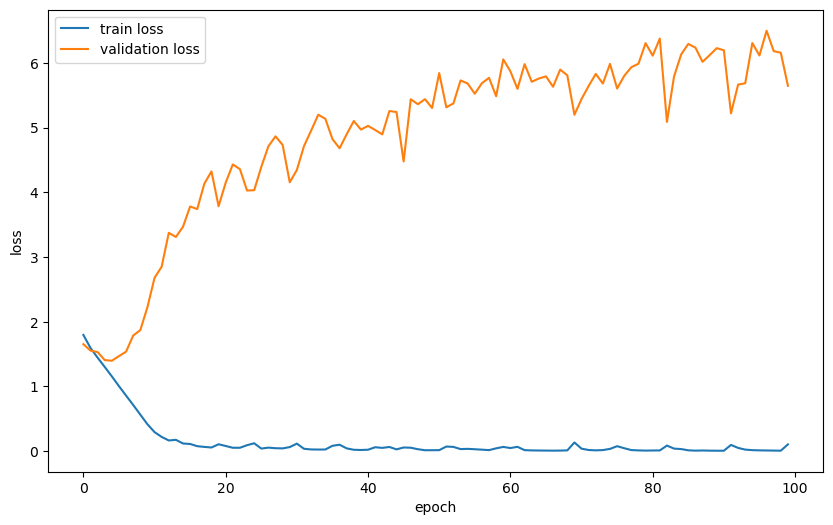

In [12]:
plt.figure(figsize = (10, 6))

plt.plot(train_avg_loss, label='train loss')
plt.plot(validation_avg_loss, label='validation loss')

plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

In [13]:
wandb.finish()

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▇▆▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
validation_loss,▂▁▁▂▄▃▄▆▂▄▆▂▄▅▆▂▅▅▂▅▅▇▅▄█▂▇▆▂▅▆▅▆▅▇▂▅██▅
epoch,99
train_loss,0.07499
validation_loss,4.80256


In [14]:
print(f"Accuracy = {validation_accuracy[-1]}, recall = {recall_scores[-1]}, precision = {precision_scores[-1]}, f1 = {f1_scores[-1]}")

Accuracy = 0.4787057638168335, recall = 0.48230704931735857, precision = 0.48387450097891127, f1 = 0.4811302064810742


In [16]:
plt.figure(figsize = (10, 6))

# modifier la boucle de train pour que les list puissent être plot si besoin
plt.plot(validation_accuracy, label='Accuracy')
plt.plot(recall_scores, label='Recall')
plt.plot(precision_scores, label='Precision')
plt.plot(f1_scores, label='f1')

plt.xlabel("epoch")
plt.ylabel("Metric")
plt.legend()
plt.show()

AttributeError: 'list' object has no attribute 'cpu'

<Figure size 1000x600 with 0 Axes>